# Airbnb New User Bookings

by Semin Kim.

(joint with Isaac Solomon from Brown University)

## Variable Description 

- id: user id
- date_account_created: the date of account creation
- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  date_first_booking because a user can search before signing up
- date_first_booking: date of first booking
- gender
- age
- signup_method
- signup_flow: the page a user came to signup up from
- language: international language preference
- affiliate_channel: what kind of paid marketing
- affiliate_provider: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
- signup_app
- first_device_type
- first_browser
- country_destination: this is the target variable you are to predict

## Summary of the exploratory analysis

General:
- 210K users with 16 features, such as age, gender, account create date, and device used. 
- 87.5% of bookings are US/NDF(no booking). 

Demographic:
- 40% of age are missing and have some outlier having >1000 age.
- Users with missing 'age' or 'gender' information significantly less likely to book. We can get information about users' seriousness at booking by looking at their profile completeness. 
- For users who booked, half of them booked in a day, and 3/4 booked in a month after creating accounts. Therefore, we might need to do more actions at the time when users create accounts. 

Signup device and booking:
- Most people signed up on The Web(85%) followed by iOS(10%). 
- Web-signup users have higher booking rate than iOS-signup users.
- A similar result for desktop vs. mobile case. (Web~Desktop, iOS~mobile) 
- Therefore, we can add a new categorical feature 'signup_device' with values in 'Mac, Windows, iOS, Else', having desktop/mobile, and Mac/Windows/iOS split in mind.  
- Signup flow 2 and 3 seems effective based on their relatively high counts and higher booking rate. 
- no useful information (yet) for signup method, language, affiliate_channel, affiliate_provider.

# 1. Explore User Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def plot_cat_cat(df, col1, col2, percent=True):
    cnt_p = df[col1].value_counts()/df[col1].value_counts().sum()
    print('\n Percents for %s.' %col1)
    print(cnt_p)
    df.groupby([col1, col2]).size().unstack().plot(kind='bar')
    
    if percent:
        gp = df.groupby([col1, col2]).size().unstack()
        gp_p = gp.div(gp.sum(1), axis=0)
        print('\n Percents for %s-%s' %(col1, col2))
        print(gp_p)
        gp_p.plot(kind='bar', stacked=True)
        overall = 0.666
        plt.plot([-1,20],[overall,overall], 'r--')

In [3]:
df = pd.read_csv('train_users_2.csv')

In [4]:
df.shape

(213451, 16)

In [5]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## country of destination (booking)

In [7]:
dest_cnt = df['country_destination'].value_counts()
dest_cnt_percent = dest_cnt/(dest_cnt.sum())*100
dest_cnt_percent

NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

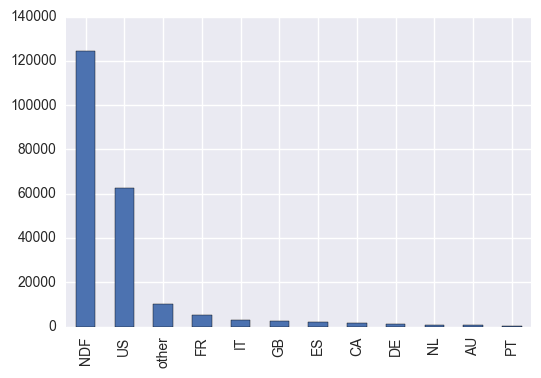

In [8]:
dest_cnt.plot(kind='bar')

- 87.5% of bookings are US/NDF(no booking). 
- We first model US/NDF binary classfication.

In [9]:
df = df[df.country_destination.isin(['NDF', 'US'])]

In [10]:
df.shape

(186919, 16)

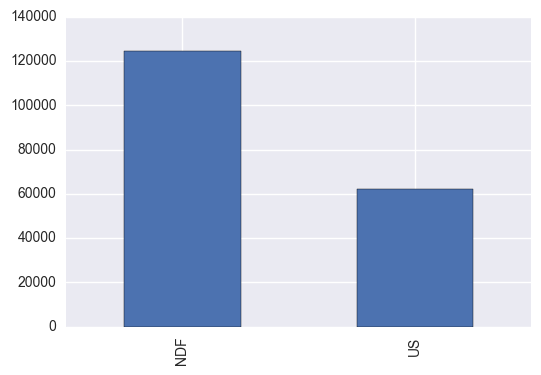

In [11]:
dest_cnt = df.country_destination.value_counts()
dest_cnt.plot(kind='bar')

In [12]:
dest_cnt_percent = dest_cnt/dest_cnt.sum()*100
dest_cnt_percent

NDF    66.629396
US     33.370604
Name: country_destination, dtype: float64

## age

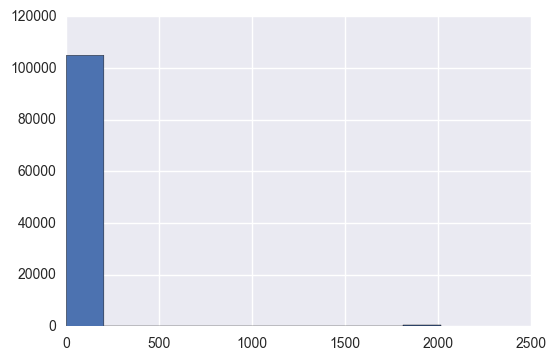

In [13]:
df.age.hist()

- 40% of age are missing. 
- We also see some outliers: age~2000. 

In [14]:
df.age.fillna(1000, inplace=True)
df['ageCat'] = pd.cut(df['age'], 
                        bins=[0,10,20,30,40,50,60,70,80,90,100,10000])


 Percents for ageCat.
(100, 10000]    0.445851
(30, 40]        0.197599
(20, 30]        0.188675
(40, 50]        0.085722
(50, 60]        0.044249
(60, 70]        0.020565
(10, 20]        0.010630
(70, 80]        0.004430
(80, 90]        0.001038
(90, 100]       0.000979
(0, 10]         0.000262
Name: ageCat, dtype: float64

 Percents for ageCat-country_destination
country_destination       NDF        US
ageCat                                 
(0, 10]              0.877551  0.122449
(10, 20]             0.637645  0.362355
(20, 30]             0.523691  0.476309
(30, 40]             0.511601  0.488399
(40, 50]             0.579916  0.420084
(50, 60]             0.594487  0.405513
(60, 70]             0.572320  0.427680
(70, 80]             0.634058  0.365942
(80, 90]             0.752577  0.247423
(90, 100]            0.819672  0.180328
(100, 10000]         0.823610  0.176390


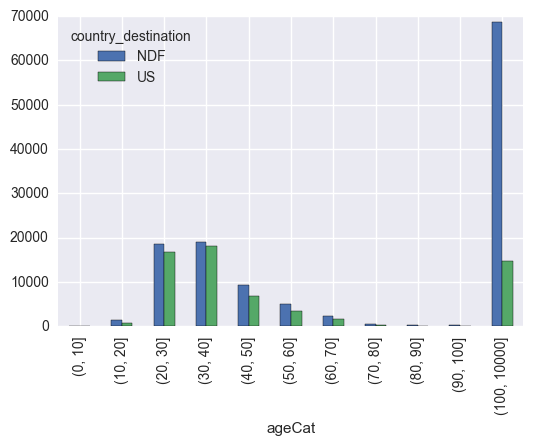

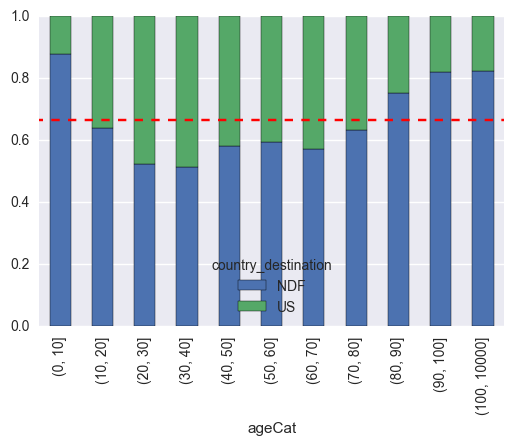

In [15]:
plot_cat_cat(df, 'ageCat', 'country_destination')

- Based on user counts, age of 20-40 and 'missing' are majority.  
- Uses of age 20-40 have relatively higher chance of booking. 
- Users with 'missing age' are much less likely to book, indicating that users without complete profile are less serious about actual bookings. 

## gender


 Percents for gender.
-unknown-    0.464260
FEMALE       0.287515
MALE         0.247037
OTHER        0.001188
Name: gender, dtype: float64

 Percents for gender-country_destination
country_destination       NDF        US
gender                                 
-unknown-            0.768273  0.231727
FEMALE               0.577723  0.422277
MALE                 0.578634  0.421366
OTHER                0.477477  0.522523


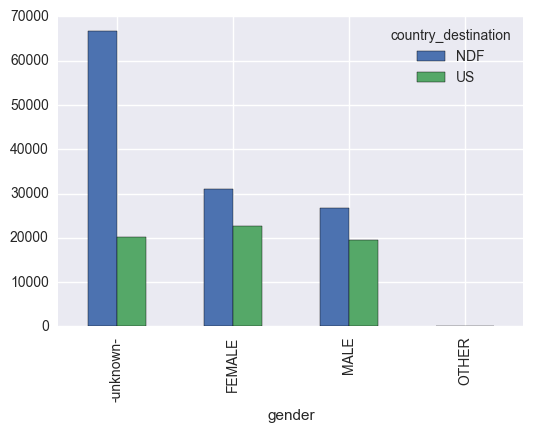

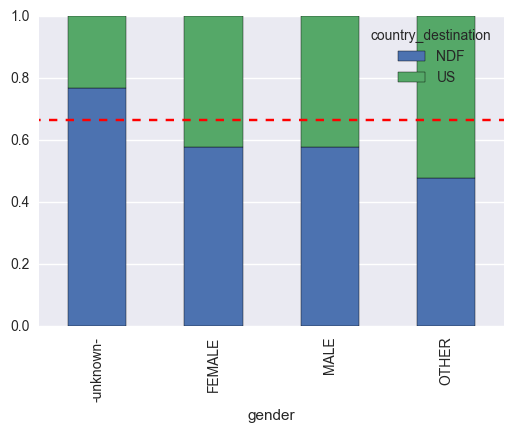

In [16]:
plot_cat_cat(df, 'gender', 'country_destination')

- Similar result with age.
- male/female have similar booking rate, while those with 'missing gender' are reposible for lower booking rate.  

## time-to-book from creating accounts. 

In [17]:
def timedelta_to_day(time_delta):
    if pd.notnull(time_delta):
        return time_delta.days
    return np.nan

df['date_account_created'] = pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'], format='%Y-%m-%d')
df['create_year'] = df.date_account_created.apply(lambda x: x.year)
df['create_month'] = df.date_account_created.apply(lambda x: x.month)
df['time_create_to_book'] = (df['date_first_booking']-df['date_account_created']).apply(timedelta_to_day)

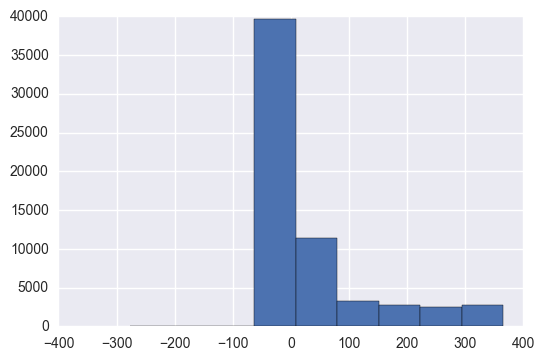

In [18]:
df['time_create_to_book'].hist()

In [19]:
(df.time_create_to_book < 0).sum()

21

- We see some negative value for time_create_to_book.
- Either error or indeed created account after booking. 
- They are only 21 users, so we remove them. 

In [20]:
df.shape

(186919, 20)

In [21]:
df = df[~(df.time_create_to_book < 0)]

In [22]:
df.shape

(186898, 20)

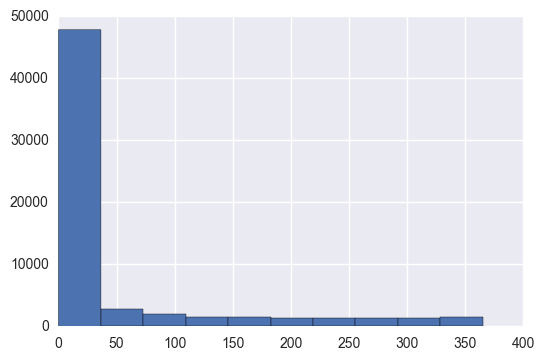

In [23]:
df['time_create_to_book'].hist()

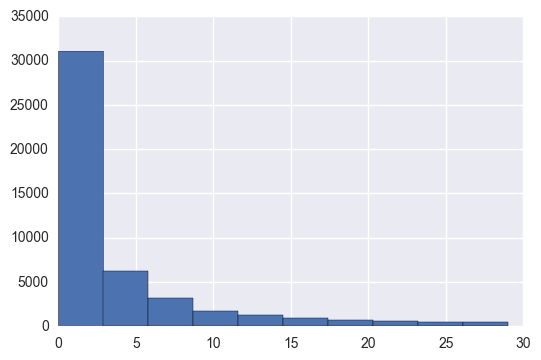

In [24]:
df[df['time_create_to_book'] < 30]['time_create_to_book'].hist()

In [25]:
df[df['time_create_to_book'].notnull()].country_destination.value_counts()

US    62355
Name: country_destination, dtype: int64

In [26]:
df[df['time_create_to_book'].isnull()].country_destination.value_counts()

NDF    124543
Name: country_destination, dtype: int64

- time_create_to_book is well-defined, null for NDF and notnull for US.

In [27]:
df['time_create_to_book_cat'] = pd.cut(df['time_create_to_book'], 
                        bins=[-0.1,1, 7, 30, 90,1000])

In [28]:
time_book_cnt = df['time_create_to_book_cat'].value_counts()
time_book_cnt_percent = time_book_cnt/time_book_cnt.sum()*100
time_book_cnt_percent

(-0.1, 1]     42.432844
(1, 7]        21.175527
(90, 1000]    17.174244
(7, 30]       11.939700
(30, 90]       7.277684
Name: time_create_to_book_cat, dtype: float64

For users who booked,  
- 42% booked in a day.
- 63% booked in a week. 
- 75% booked in a month
- 82% booked in 3 months
since they joined. 

# Other Variables
- signup_method
- signup_flow
- language
- affiliate_channel
- affiliate_provider
- first_affiliate_tracked
- signup_app
- first_device_type
- first_browser

## Summary
- Most people signed up on The Web(85%) followed by iOS(10%). 
- Web-signup users have higher booking rate than iOS-signup users.
- A similar result for desktop vs. mobile case. (Web~Desktop, iOS~mobile) 
- Therefore, we can add a new categorical feature 'device' with values in 'Mac, Windows, iOS, Else', having desktop/mobile, and Mac/Windows/iOS split in mind.  
- Signup flow 2 and 3 seems effective based on their relatively high counts and higher booking rate. 
- no useful information (yet) for signup method, language, affiliate_channel, affiliate_provider.

## List of charts. (can be skipped)
We present a series of charts for above analysis.

In [29]:
def get_language(s):
    if s == 'en':
        return s
    else:
        return 'not en'

def get_device(s):
    if s in ['Mac Desktop', 'Windows Desktop', 'iPhone', 'iPad']:
        return s.split(' ')[0]
    else:
        return 'Else'

def get_affiliate_provider(s):
    if s in ['direct', 'google']:
        return s
    else:
        return 'other'

def get_affiliate_channel(s):
    if s == 'direct':
        return s
    else:
        return 'other'
    
def get_browser(s):
    if s in ['Chrome', 'Safari', 'Firefox', 'IE', '-unknown-', 
             'Android Browser', 'Mobile Safari', 'Chrome Mobile']:
        return s
    else:
        return 'Else'

In [30]:
df['language'] = df['language'].apply(get_language)
df['first_device_type'] = df['first_device_type'].apply(get_device)
df['affiliate_provider'] = df['affiliate_provider'].apply(get_affiliate_provider)
df['affiliate_channel'] = df['affiliate_channel'].apply(get_affiliate_channel)
df['first_browser'] = df['first_browser'].apply(get_browser)


 Percents for signup_app.
Web        0.847093
iOS        0.094083
Moweb      0.031226
Android    0.027598
Name: signup_app, dtype: float64

 Percents for signup_app-country_destination
country_destination       NDF        US
signup_app                             
Android              0.818340  0.181660
Moweb                0.705620  0.294380
Web                  0.648661  0.351339
iOS                  0.768198  0.231802


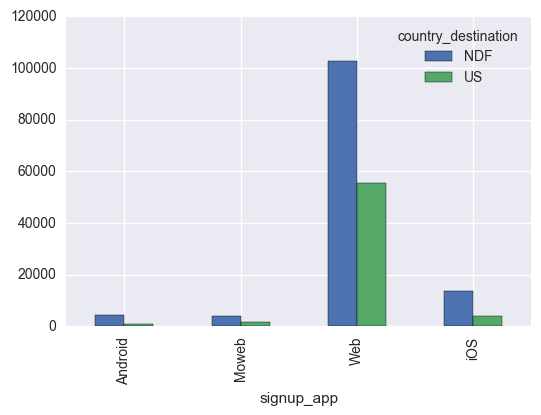

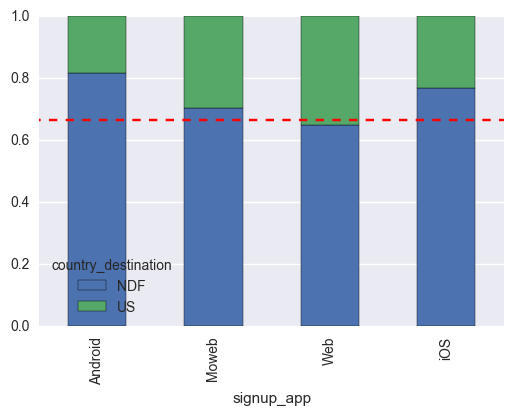

In [31]:
plot_cat_cat(df, 'signup_app', 'country_destination')


 Percents for first_device_type.
Mac        0.411519
Windows    0.339581
iPhone     0.102500
Else       0.079428
iPad       0.066972
Name: first_device_type, dtype: float64

 Percents for first_device_type-country_destination
country_destination       NDF        US
first_device_type                      
Else                 0.768744  0.231256
Mac                  0.615639  0.384361
Windows              0.670648  0.329352
iPad                 0.709036  0.290964
iPhone               0.748656  0.251344


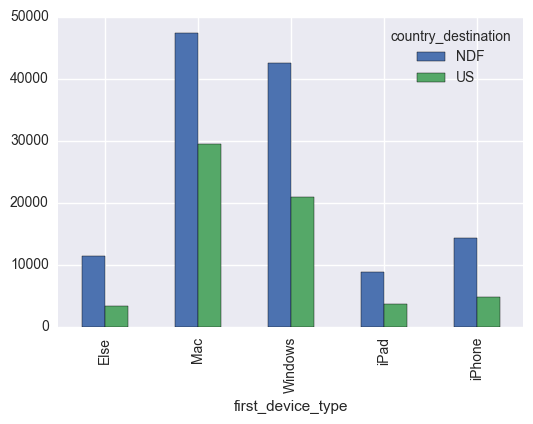

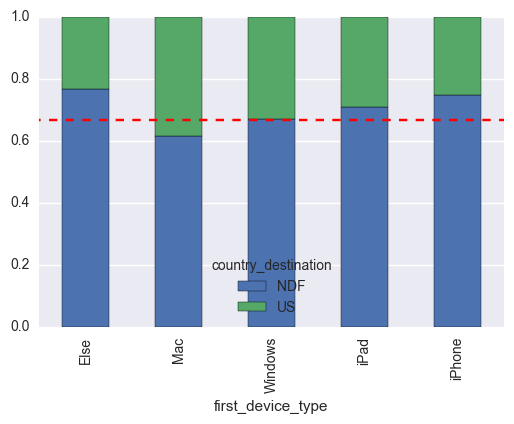

In [32]:
plot_cat_cat(df, 'first_device_type', 'country_destination')


 Percents for first_browser.
Chrome             0.294407
Safari             0.209034
Firefox            0.154748
-unknown-          0.135240
IE                 0.099493
Mobile Safari      0.091563
Chrome Mobile      0.006233
Else               0.005094
Android Browser    0.004189
Name: first_browser, dtype: float64

 Percents for first_browser-country_destination
country_destination       NDF        US
first_browser                          
-unknown-            0.777338  0.222662
Android Browser      0.729246  0.270754
Chrome               0.617331  0.382669
Chrome Mobile        0.739914  0.260086
Else                 0.717437  0.282563
Firefox              0.619770  0.380230
IE                   0.717666  0.282334
Mobile Safari        0.706656  0.293344
Safari               0.651377  0.348623


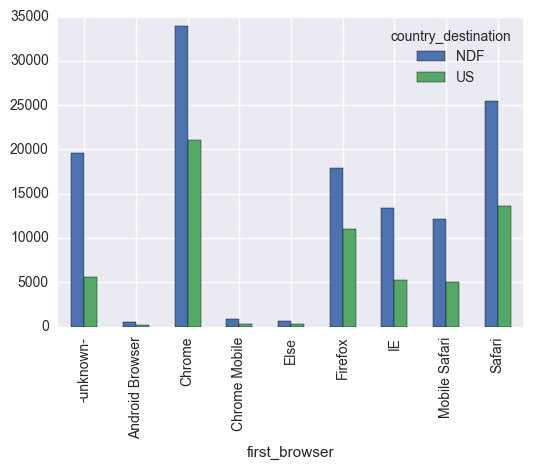

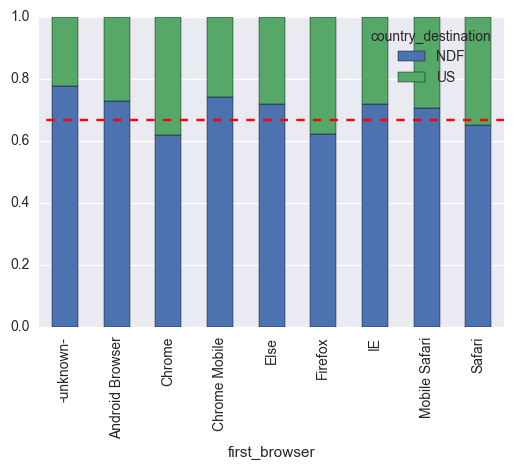

In [33]:
plot_cat_cat(df, 'first_browser', 'country_destination')


 Percents for signup_flow.
0     0.767312
25    0.072767
12    0.046079
3     0.037994
2     0.031172
24    0.021536
23    0.014291
1     0.005340
6     0.001316
8     0.000958
21    0.000856
5     0.000193
20    0.000075
16    0.000048
15    0.000048
10    0.000011
4     0.000005
Name: signup_flow, dtype: float64

 Percents for signup_flow-country_destination
country_destination       NDF        US
signup_flow                            
0                    0.661360  0.338640
1                    0.879760  0.120240
2                    0.549605  0.450395
3                    0.451627  0.548373
4                    1.000000       NaN
5                    0.944444  0.055556
6                    0.556911  0.443089
8                    0.720670  0.279330
10                   0.500000  0.500000
12                   0.727357  0.272643
15                   0.666667  0.333333
16                   1.000000       NaN
20                   0.857143  0.142857
21                   0.700000  0.300

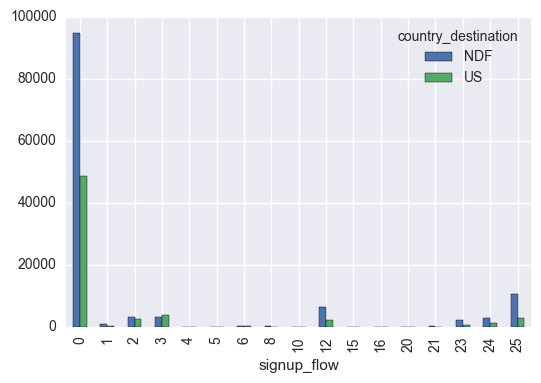

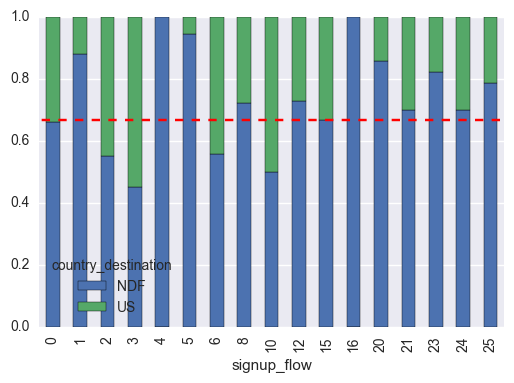

In [34]:
plot_cat_cat(df, 'signup_flow', 'country_destination')


 Percents for affiliate_channel.
direct    0.642249
other     0.357751
Name: affiliate_channel, dtype: float64

 Percents for affiliate_channel-country_destination
country_destination       NDF        US
affiliate_channel                      
direct               0.652551  0.347449
other                0.691174  0.308826


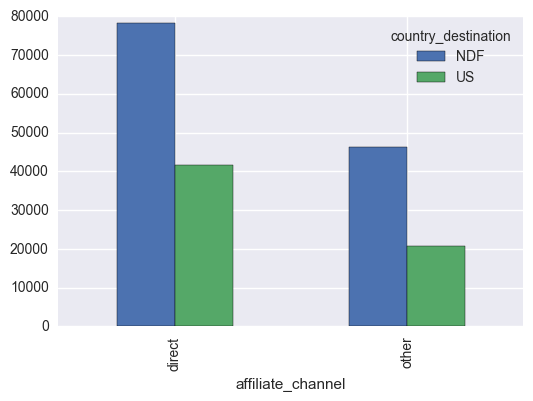

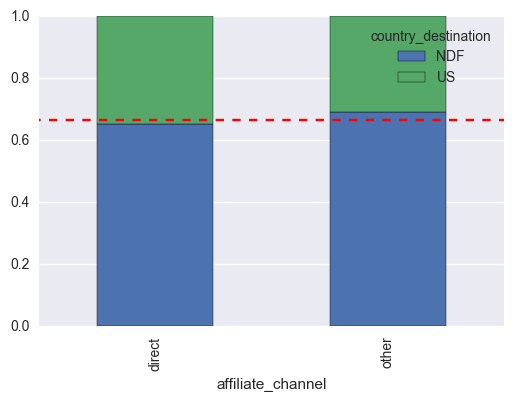

In [38]:
plot_cat_cat(df, 'affiliate_channel', 'country_destination')


 Percents for affiliate_provider.
direct    0.640932
google    0.240334
other     0.118733
Name: affiliate_provider, dtype: float64

 Percents for affiliate_provider-country_destination
country_destination       NDF        US
affiliate_provider                     
direct               0.652748  0.347252
google               0.688232  0.311768
other                0.695642  0.304358


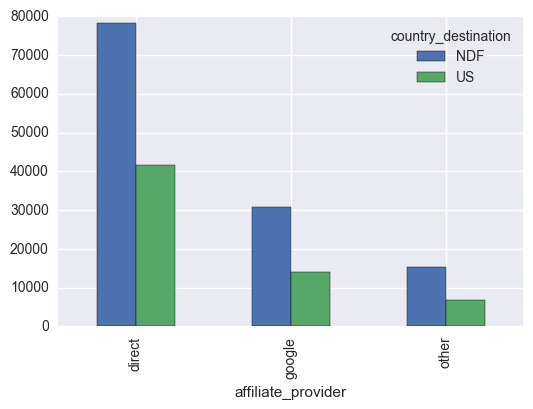

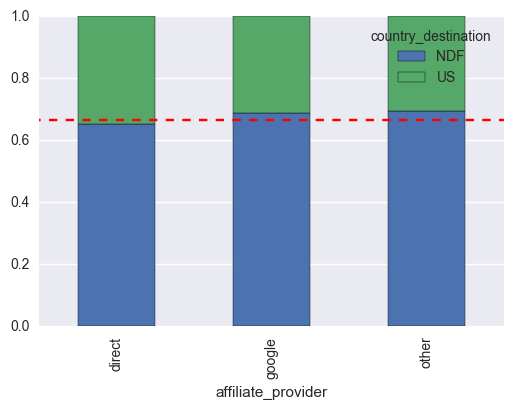

In [39]:
plot_cat_cat(df, 'affiliate_provider', 'country_destination')


 Percents for signup_method.
basic       0.713009
facebook    0.284187
google      0.002804
Name: signup_method, dtype: float64

 Percents for signup_method-country_destination
country_destination       NDF        US
signup_method                          
basic                0.659208  0.340792
facebook             0.682532  0.317468
google               0.849237  0.150763


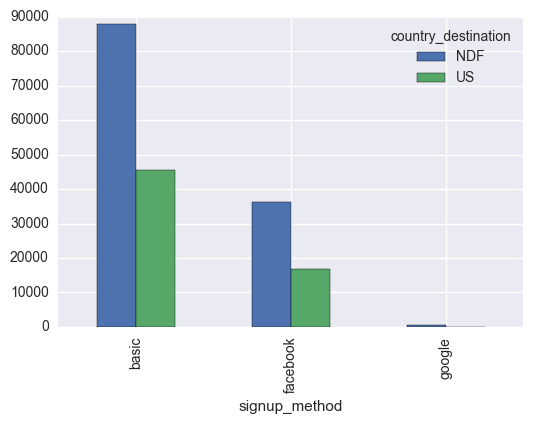

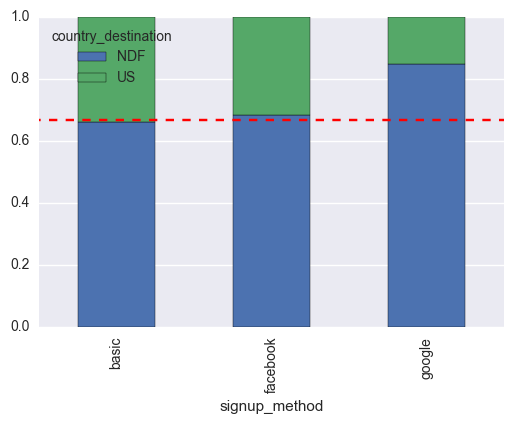

In [40]:
plot_cat_cat(df, 'signup_method', 'country_destination')